# 2. Cross-Entropie a modelování jazyka

### Rozdělení na datasety:
* posledních 20 000 testovací data
* posledních 40 000 ze zbytku heldout data
* zbytek trénovací data

### Spočítat pravděpodobnosti
$T$ velikost textu, $V$ velikost slovníku  
$
p_0(w_i) = \dfrac{1}{V}\\
p_1(w_i) = \dfrac{c_1(w_i)}{T}\\
p_2(w_i|w_{i-1}) = \dfrac{c_2(w_{i-1},w_i)}{c_1({w_{i-1})}}\\
p_3(w_i|w_{i-2},w_{i-1}) = \dfrac{c_3(w_{i-2},w_{i-1},w_i)}{c_2(w_{i-1},w_i)}
$

### EM algoritmus
Vypočítat parametry z heldout dat (také z trénovacích a poté zahodit)
$$p_s(w_i|w_{i-2},w_{i-1}) = l_0p_0(w_i) + l_1p_1(w_i) + l_2p_2(w_i|w_{i-1})+l_3p_3(w_i|w_{i-2},w_{i-1})$$
pro $l_0+l_1+l_2+l_3 = 1$

### Vypočítat cross-entropii
Poupravit parametry vyhlazení následujícím způsobem: přidat $10\%​$, $20\%​$, $\ldots​$,$90\%​$, $95\%​$ a $99\%​$ rozdílu mezi trigram vyhlazení a $1.0​$ k jeho hodnotě, proporciálně uprav zbývající tři parametry (připomeňme, že mají součet 1!!). Potom nastavte trigram vyhlazovací parametr na $90\%​$, $80\%​$, $\ldots​$, $10\%​$, $0\%​$ z jeho hodnoty a proporciálně uprav zbývající parametry. Vypočítejte cross-entropii na testovacích datech pro těchto 22 příkladů 

## Importy

In [1]:
import numpy as np
import random
from enum import IntEnum
import sys
import math
from tqdm import tqdm, tnrange, tqdm_notebook
import time
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

## Konstanty
Nastavení hlavních parametrů

In [2]:
FILES = ["TEXTEN1.txt", "TEXTCZ1.txt"]
TESTDATASIZE = 20*1000
HELDOUTDATASIZE = 40*1000
TRANSFORMTYPE = IntEnum('TRANSFORM', 'INCREASE DECREASE')
TRANSFORMINC = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
TRANSFORMDEC = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
EPSILON = 1e-10
DEBUG = False
SEED = 84840014

COUNTS_WORDS = {}
COUNTS_PAIRS = {}
COUNTS_TRIPLES = {}
T = 0

## Načtení dat ze souboru
Načtení dat do listu

In [3]:
def get_data(file):
    with open(file, "r") as f:
        data = np.array([x.replace("\n", "") for x in f.readlines()])
        
    if(DEBUG):
        print("Metoda: get_data")
        print("Soubor: ",file)
        print("Výsledek: ",data)
        print()
        
    return data

## Vytvoření datasetů a četností uni-,bi-,tri-gramů
Vytvoření datasetů rozřezáním původního listu.
Spočítání četností a uložení do slovníků typu (i,j,k):c(i,j,k)

In [4]:
def create_datasets(data):
    test_data = data[-TESTDATASIZE:]
    heldout_data = data[-(TESTDATASIZE+HELDOUTDATASIZE):-TESTDATASIZE]
    train_data = data[:-(TESTDATASIZE+HELDOUTDATASIZE)]
        
    return (train_data,heldout_data,test_data)

def create_counts(data):
    # Odečíst 1 od četnosti posledního slova, protože to už nemá dvojici a já chci z toho počítat psti
    words, counts = np.unique(data, return_counts=True)
    counts_words = dict(zip(words,counts))
    
    counts_words[data[-1]] -= 1
    
    counts_pairs = dict()
    for i in range(data.size - 1):
        if (data[i],data[i+1]) in counts_pairs:
            counts_pairs[(data[i],data[i+1])] += 1
        else:
            counts_pairs[(data[i],data[i+1])] = 1
    
    counts_triples = dict()
    for i in range(data.size - 2):
        if (data[i],data[i+1],data[i+2]) in counts_triples:
            counts_triples[(data[i],data[i+1],data[i+2])] += 1
        else:
            counts_triples[(data[i],data[i+1],data[i+2])] = 1
        
    return (counts_words,counts_pairs,counts_triples)

## Pomocné funkce

### Výpočet pravděpodobností uni, bi, tri gramů
Kontrola a řešení problémů s dělení 0 a následné vypočítání pravděpodobnosti podle vzorců. Při případném dělení 0 se používá pravděpodobnost $p_0$ viz slajdy předmětu.

In [5]:
def p0():
    return 1/len(COUNTS_WORDS)

def p1(w1):
    if w1 not in COUNTS_WORDS:
        return 0
    return COUNTS_WORDS[w1]/T

def p2(w1,w2):
    if w1 not in COUNTS_WORDS or COUNTS_WORDS[w1]==0:
        return p0()
    if not (w1,w2) in COUNTS_PAIRS:
        return 0
    return COUNTS_PAIRS[(w1,w2)]/COUNTS_WORDS[w1]

def p3(w1,w2,w3):
    if (w1,w2) not in COUNTS_PAIRS or COUNTS_PAIRS[(w1,w2)] == 0:
        return p0()
    if not (w1,w2,w3) in COUNTS_TRIPLES:
        return 0
    return COUNTS_TRIPLES[(w1,w2,w3)]/COUNTS_PAIRS[(w1,w2)]
    

### Výpočet $p'_{\lambda}(w_i|h_i)$

In [6]:
def p_lambda(w1,w2,w3,lambdas):
    return lambdas[3]*p3(w1,w2,w3) \
          +lambdas[2]*p2(w2,w3) \
          +lambdas[1]*p1(w3) \
          +lambdas[0]*p0()

## EM algoritmus
Dokud se mění parametry o více než $\epsilon$ provádí se výpočet, kde jsou spočítané očekávané hodnoty za použití aktuálních parametrů a následné jejich updatování.

In [7]:
def EM(epsilon, heldout_data):
    lambdas = [0.25]*4
    history = [lambdas]
    
    last_value = 0
    with tqdm_notebook(total=1000,desc="EM", leave=False) as pbar:
    
        while(True):
            expected_counts = [0]*4

            for i in range(heldout_data.size-2):
                p_lam = p_lambda(heldout_data[i],heldout_data[i+1],heldout_data[i+2],lambdas)
                if(p_lam==0):
                    continue
                expected_counts[0] += lambdas[0]*p0()\
                                     /p_lam
                expected_counts[1] += lambdas[1]*p1(heldout_data[i+2])\
                                     /p_lam
                expected_counts[2] += lambdas[2]*p2(heldout_data[i+1],heldout_data[i+2])\
                                     /p_lam
                expected_counts[3] += lambdas[3]*p3(heldout_data[i],heldout_data[i+1],heldout_data[i+2])\
                                     /p_lam

            new_lambdas = [x/sum(expected_counts) for x in expected_counts]

            is_end = True
            maximum = 0
            for i in range(len(lambdas)):
                if(abs(lambdas[i]-new_lambdas[i]) > maximum):
                    maximum = abs(lambdas[i]-new_lambdas[i])
                if(abs(lambdas[i]-new_lambdas[i])>epsilon):
                    is_end = False
                    break

            if is_end:
                pbar.update(1000-pbar.last_print_n)
                break

            lambdas = new_lambdas
            history.append(lambdas)
            
            #Progress bar
            new_value = 1/math.log(EPSILON,10)*math.log(maximum,10)
            pbar.update(int((new_value - last_value)*1000) if new_value - last_value > 0 else 0)
            last_value = new_value if new_value > last_value else last_value
    
        
    
    return (lambdas,history)

## Cross-Entropie

In [8]:
def entropy(data, lambdas):
    H = 0
    for i in range(data.size-2):
        H -= math.log2(p_lambda(data[i],data[i+1],data[i+2],lambdas))
        
    return H/(data.size-2)

## Změna lambdy
Pomocné metody k změnění parametrů o určitá procenta. Vypočte se nová $\lambda_3$ a poté se poměrově zbytek hodnoty přiřadí ostatním parametrům.

In [9]:
def lambda_increase(lambdas, perc):
    lambdas[-1] += (1 - lambdas[-1])*perc
    ratio = (sum(lambdas)-lambdas[-1])/(1-lambdas[-1])
    lambdas = [x/ratio for x in lambdas]
    lambdas[-1] *= ratio
    return lambdas

def lambda_decrease(lambdas, perc):
    lambdas[-1] *= perc
    ratio = (sum(lambdas)-lambdas[-1])/(1-lambdas[-1])
    lambdas = [x/ratio for x in lambdas]
    lambdas[-1] *= ratio
    return lambdas
    

## Zobrazení výsledků

In [10]:
def show_results(results):
    for i in range(len(FILES)):
        for j in range(len(TRANSFORMTYPE)):
            if (j+1)==int(TRANSFORMTYPE.INCREASE):
                df1 = pd.DataFrame(results[i,j,:len(TRANSFORMINC),:],index=TRANSFORMINC, columns=["$\lambda_0$","$\lambda_1$","$\lambda_2$","$\lambda_3$","Entropie"])
                graph = pd.DataFrame(results[i,j,:len(TRANSFORMINC),-1],index=TRANSFORMINC, columns=[str(FILES[i] + " - " + str(TRANSFORMTYPE(j+1)).split(".")[1])])
            if (j+1)==int(TRANSFORMTYPE.DECREASE):
                df1 = pd.DataFrame(results[i,j,:len(TRANSFORMDEC),:],index=TRANSFORMDEC, columns=["$\lambda_0$","$\lambda_1$","$\lambda_2$","$\lambda_3$","Entropie"])
                graph = pd.DataFrame(results[i,j,:len(TRANSFORMDEC),-1],index=[1-x for x in TRANSFORMDEC], columns=[str(FILES[i] + " - " + str(TRANSFORMTYPE(j+1)).split(".")[1])])
                
            plt.plot(graph, label=str(FILES[i] + " - " + str(TRANSFORMTYPE(j+1)).split(".")[1]))
            plt.plot(graph, 'k|')
            
            for col in df1.columns:
                df1[col] = df1[col].map('{:,.10f}'.format)
            
            display(HTML("<h2>" + FILES[i] + " - " + str(TRANSFORMTYPE(j+1)).split(".")[1] + "</h2>"))
            display(df1)
            
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Zvýšení/snížení $\lambda_3$')
    plt.ylabel('Cross-Entropie')
    plt.title('Graf Cross-Entropie')
    plt.show()

def show_lambdas(lambdas):    
    for i in range(len(FILES)):
        df1 = pd.DataFrame(lambdas[i], columns=["$\lambda_0$","$\lambda_1$","$\lambda_2$","$\lambda_3$"])
        for col in df1.columns:
            df1[col] = df1[col].map('{:,.10f}'.format)
        display(HTML("<h2>" + FILES[i] + "</h2>"))
        display(df1)

## Graf pokrytí
Výpočet a vykreslení grafu. 

In [11]:
def coverage(test_data):
    test_counts = create_counts(test_data)
    train_counts = (COUNTS_WORDS,COUNTS_PAIRS,COUNTS_TRIPLES)
    cov = [0]*3
    for i in range(len(cov)):
        for t in test_counts[i]:
            if t in train_counts[i]:
                cov[i] += test_counts[i][t]
        cov[i] /= sum([test_counts[i][x] for x in test_counts[i]])
    return cov

def show_coverage(results):
    df1 = pd.DataFrame(results, columns=["Uni-gram", "Bi-gram", "Tri-gram"], index=FILES)
    df1 = df1.transpose()
    display(df1)
    
    colors = ["r","b","g"]
    n_groups = 3

    index = np.arange(n_groups)
    bar_width = 0.8/len(FILES)

    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    
    for i in range(len(results)):
        plt.bar(index + i*bar_width, results[i], bar_width,
                         alpha=opacity,
                         color=colors[i%len(colors)],
                         label=FILES[i])

    plt.xlabel('n-gram')
    plt.ylabel('Pokrytí')
    plt.title('Graf pokrytí')
    plt.xticks(index + bar_width*len(FILES) / 2, ('Uni-gram', 'Bi-gram', 'Tri-gram'))
    plt.legend()

    plt.tight_layout()
    plt.show()

## Main
### Hlavní cyklus
Projdou se všechny soubory.
Z každého souboru jsou vytvořeny datasety, spočítány uni-,bi-,tri-gramy a je spuštěn EM algoritmus.
Poté se spočítána cross-entropie pro všechna požadovaná nastavení parametrů. 


Time:  3 m  42 s



,$\lambda_0$,$\lambda_1$,$\lambda_2$,$\lambda_3$
0,0.2500000000,0.2500000000,0.2500000000,0.2500000000
1,0.1167225989,0.2514594534,0.3922685188,0.2395494289
2,0.0847611305,0.2490138807,0.4500333134,0.2161916753
3,0.0751590871,0.2503157295,0.4729723925,0.2015527909
4,0.0718728325,0.2519520613,0.4827689266,0.1934061796
5,0.0706822968,0.2530183923,0.4873265040,0.1889728068
6,0.0702485407,0.2535824570,0.4896026037,0.1865663986
7,0.0700982059,0.2538479539,0.4907970868,0.1852567535
8,0.0700537346,0.2539612547,0.4914440006,0.1845410101
9,0.0700468531,0.2540039738,0.4918011264,0.1841480466


,$\lambda_0$,$\lambda_1$,$\lambda_2$,$\lambda_3$
0,0.2500000000,0.2500000000,0.2500000000,0.2500000000
1,0.1899333114,0.3565384785,0.2513176208,0.2022105893
2,0.1641245035,0.4007131077,0.2486312278,0.1865311609
3,0.1526923559,0.4177170910,0.2471064413,0.1824841118
4,0.1472225773,0.4242560715,0.2462761313,0.1822452199
5,0.1443831160,0.4268411933,0.2457541713,0.1830215193
6,0.1427990662,0.4279156949,0.2453963927,0.1838888463
7,0.1418642966,0.4283951015,0.2451463654,0.1845942364
8,0.1412903092,0.4286279174,0.2449731459,0.1851086276
9,0.1409285256,0.4287510766,0.2448548613,0.1854655366


,$\lambda_0$,$\lambda_1$,$\lambda_2$,$\lambda_3$
0,0.2500000000,0.2500000000,0.2500000000,0.2500000000
1,0.0026777600,0.0348104979,0.2006972440,0.7618144981
2,0.0000131842,0.0026745507,0.0783927207,0.9189195444
3,0.0000000585,0.0001956542,0.0287546342,0.9710496531
4,0.0000000003,0.0000141677,0.0104382616,0.9895475704
5,0.0000000000,0.0000010231,0.0037802144,0.9962187624
6,0.0000000000,0.0000000738,0.0013680878,0.9986318384
7,0.0000000000,0.0000000053,0.0004950145,0.9995049802
8,0.0000000000,0.0000000004,0.0001790975,0.9998209021
9,0.0000000000,0.0000000000,0.0000647962,0.9999352037


,$\lambda_0$,$\lambda_1$,$\lambda_2$,$\lambda_3$
0,0.2500000000,0.2500000000,0.2500000000,0.2500000000
1,0.0002187048,0.0118670333,0.2053978789,0.7825163829
2,0.0000000818,0.0002775057,0.0786837976,0.9210386149
3,0.0000000000,0.0000062118,0.0289201173,0.9710736708
4,0.0000000000,0.0000001379,0.0105331000,0.9894667621
5,0.0000000000,0.0000000031,0.0038265598,0.9961734371
6,0.0000000000,0.0000000001,0.0013891092,0.9986108908
7,0.0000000000,0.0000000000,0.0005041512,0.9994958488
8,0.0000000000,0.0000000000,0.0001829573,0.9998170427
9,0.0000000000,0.0000000000,0.0000663936,0.9999336064


,$\lambda_0$,$\lambda_1$,$\lambda_2$,$\lambda_3$,Entropie
0.00,0.0700761971,0.2540049547,0.4922594755,0.1836593727,7.4685164076
0.10,0.0630685773,0.2286044593,0.4430335280,0.2652934354,7.4700973606
0.20,0.0560609576,0.2032039638,0.3938075804,0.3469274982,7.4969927508
0.30,0.0490533379,0.1778034683,0.3445816329,0.4285615609,7.5467698528
0.40,0.0420457182,0.1524029728,0.2953556853,0.5101956236,7.6204790432
0.50,0.0350380985,0.1270024774,0.2461297378,0.5918296864,7.7223233454
0.60,0.0280304788,0.1016019819,0.1969037902,0.6734637491,7.8610268679
0.70,0.0210228591,0.0762014864,0.1476778427,0.7550978118,8.0541442064
0.80,0.0140152394,0.0508009909,0.0984518951,0.8367318745,8.3418290591
0.90,0.0070076197,0.0254004955,0.0492259476,0.9183659373,8.8510590988


,$\lambda_0$,$\lambda_1$,$\lambda_2$,$\lambda_3$,Entropie
1.0,0.0700761971,0.2540049547,0.4922594755,0.1836593727,7.4685164076
0.9,0.0716527632,0.2597195289,0.5033342724,0.1652934354,7.4723589030
0.8,0.0732293294,0.2654341031,0.5144090693,0.1469274982,7.4780701337
0.7,0.0748058956,0.2711486773,0.5254838662,0.1285615609,7.4858966602
0.6,0.0763824618,0.2768632514,0.5365586631,0.1101956236,7.4961755430
0.5,0.0779590280,0.2825778256,0.5476334600,0.0918296864,7.5093852221
0.4,0.0795355942,0.2882923998,0.5587082569,0.0734637491,7.5262426076
0.3,0.0811121604,0.2940069739,0.5697830538,0.0550978118,7.5479128503
0.2,0.0826887266,0.2997215481,0.5808578507,0.0367318745,7.5765575585
0.1,0.0842652928,0.3054361223,0.5919326476,0.0183659373,7.6173517820


,$\lambda_0$,$\lambda_1$,$\lambda_2$,$\lambda_3$,Entropie
0.00,0.1402643298,0.4289372102,0.2446182953,0.1861801647,10.2208745744
0.10,0.1262378968,0.3860434892,0.2201564658,0.2675621482,10.2253541802
0.20,0.1122114638,0.3431497682,0.1956946363,0.3489441317,10.2548136581
0.30,0.0981850309,0.3002560472,0.1712328067,0.4303261153,10.3069213223
0.40,0.0841585979,0.2573623261,0.1467709772,0.5117080988,10.3827127929
0.50,0.0701321649,0.2144686051,0.1223091477,0.5930900823,10.4862783639
0.60,0.0561057319,0.1715748841,0.0978473181,0.6744720659,10.6260798434
0.70,0.0420792989,0.1286811631,0.0733854886,0.7558540494,10.8190774891
0.80,0.0280528660,0.0857874420,0.0489236591,0.8372360329,11.1038523521
0.90,0.0140264330,0.0428937210,0.0244618295,0.9186180165,11.6013904191


,$\lambda_0$,$\lambda_1$,$\lambda_2$,$\lambda_3$,Entropie
1.0,0.1402643298,0.4289372102,0.2446182953,0.1861801647,10.2208745744
0.9,0.1434732017,0.4387501439,0.2502145062,0.1675621482,10.2240601916
0.8,0.1466820736,0.4485630775,0.2558107172,0.1489441317,10.2291426565
0.7,0.1498909455,0.4583760112,0.2614069281,0.1303261153,10.2363751923
0.6,0.1530998174,0.4681889448,0.2670031390,0.1117080988,10.2461075907
0.5,0.1563086893,0.4780018785,0.2725993499,0.0930900823,10.2588433397
0.4,0.1595175612,0.4878148121,0.2781955608,0.0744720659,10.2753514558
0.3,0.1627264331,0.4976277457,0.2837917718,0.0558540494,10.2969158646
0.2,0.1659353050,0.5074406794,0.2893879827,0.0372360329,10.3260146914
0.1,0.1691441769,0.5172536130,0.2949841936,0.0186180165,10.3689846354


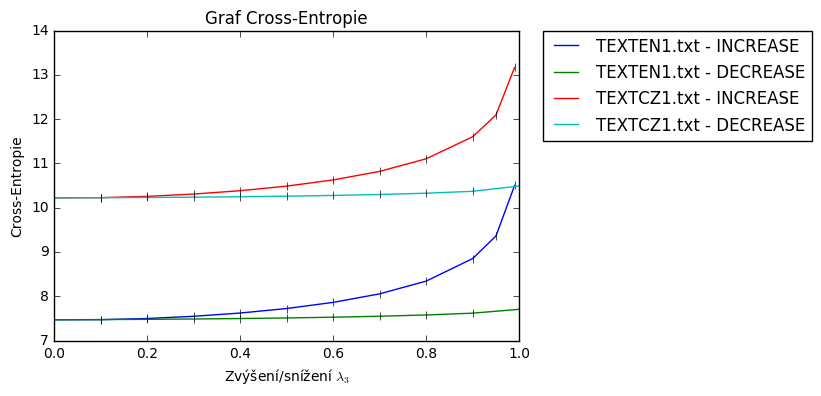

,TEXTEN1.txt,TEXTCZ1.txt
Uni-gram,0.955602,0.864557
Bi-gram,0.690615,0.420479
Tri-gram,0.340300,0.175450


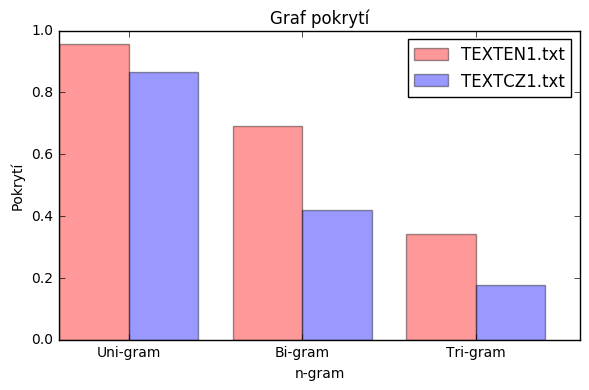

In [12]:
print()
start = time.time()
results = np.empty(shape=(len(FILES), len(TRANSFORMTYPE), max(len(TRANSFORMINC),len(TRANSFORMDEC)), 5))
lambdas_history = []
lambdas_history_train = []
coverages = []
for file in tqdm_notebook(FILES, desc='File', leave = False):
    data = get_data(file)
    (train_data,heldout_data,test_data) = create_datasets(data)
    
    train_data = np.concatenate((np.array(["<<s>>","<s>"]),train_data))
    heldout_data = np.concatenate((np.array(["<<s>>","<s>"]),heldout_data))
    test_data = np.concatenate((np.array(["<<s>>","<s>"]),test_data))
    
    T = train_data.size
    (COUNTS_WORDS,COUNTS_PAIRS,COUNTS_TRIPLES) = create_counts(train_data)
    
    (lambdas,history) = EM(EPSILON,heldout_data)
    lambdas_history.append(history)
    
    (fold,history) = EM(EPSILON,train_data)
    lambdas_history_train.append(history)
    
    coverages.append(coverage(test_data))
    for transform_type in tqdm_notebook(TRANSFORMTYPE, desc='Transf', leave = False):
        if transform_type == TRANSFORMTYPE.INCREASE:
            for transform_inc in tqdm_notebook(TRANSFORMINC, desc='Inc', leave = False):
                new_lambdas = lambda_increase(list(lambdas),transform_inc)
                H = entropy(test_data,new_lambdas)
                #print(new_lambdas)
                #print(H)
                results[FILES.index(file),int(transform_type)-1, TRANSFORMINC.index(transform_inc),:] = new_lambdas + [H]
                
        if transform_type == TRANSFORMTYPE.DECREASE:
            for transform_dec in tqdm_notebook(TRANSFORMDEC, desc='Dec', leave = False):
                new_lambdas = lambda_decrease(list(lambdas),transform_dec)
                H = entropy(test_data,new_lambdas)
                #print(new_lambdas)
                #print(H)
                results[FILES.index(file),int(transform_type)-1, TRANSFORMDEC.index(transform_dec),:] = new_lambdas + [H]

                
end = time.time()
print("Time: ",int((end-start)//60) ,"m ",int((end-start)%60) ,"s")
print()

display(HTML("<h1>Průběžné výsledky EM algoritmu</h1>"))                
show_lambdas(lambdas_history)
display(HTML("<h1>Průběžné výsledky EM algoritmu na trénovacích datech</h1>"))                
show_lambdas(lambdas_history_train)
display(HTML("<h1>Nastavení $\lambda_i$ a entropie</h1>")) 
show_results(results)
display(HTML("<h1>Pokrytí</h1>"))
show_coverage(coverages)

## Shrnutí výsledků


### Nastavení parametrů a entropie původních textů
|             |Anglický text|Český text|
|-------------|------------:|---------:|
|$\lambda_0$  |0.070076     |0.140264  |
|$\lambda_1$  |0.254005     |0.428937  |
|$\lambda_2$  |0.492259     |0.244618  |
|$\lambda_3$  |0.183659     |0.186180  |
|Entropie     |7.468516     |10.220875 |

Vidíme, že v anglickém textu měli největší váhu bi-gramy, zatímco u českého textu to byly uni-gramy.
Myslím si, že je to způsobeno tím, že anglický text má daleko vyšší pokrytí a menší slovní zásobu. Angličtina má také pevnou vetnou konstrukci tedy se určité dvojice slov budou vyskytovat často.

### Nastavení parametrů při výpočtu na trénovacích datech
Při běhu EM algoritmu na trénovacích datech dostaneme 1 u parametru $\lambda_3$ a u ostatních 0 (na velikosti $\epsilon$ záleží kolik předchozích parametrů se úplně vynuluje).
To je způsobeno tím, že pro všechny trojice dokážeme spočítat pravděpodobnost jejich výskytu a proto, že podmíněná pravděpodobnost trojice (2 slova z historie a jedno aktuální) je větší rovna podmíněné pravděpodobnosti dvojice (pouze jedno slovo z historie). 
A protože EM algoritmus maximaluzuje očekávanou hodnotu, musí tedy vynulovat všechny parametry kromě $\lambda_3$.

### Zvýšení parametru $\lambda_3$
Při zvyšování parametru $\lambda_3$ rychle roste cross-entropie. 
To je dáno tím, že díky zvětšení $\lambda_3$ máme pocit, že s vyšší pravděpodobností dokážeme odhadnou trojici, ale protože jsme parametr zvětšili uměle, tato představa je milná a nemáme nic, čím bychom to mohli napravit.
Tedy čím více zvětšujeme $\lambda_3$, tím častěji máme chybný odhad a proto se entropie zvětšuje.

### Snížení parametru $\lambda_3$
Zde cross-entropie také roste, ale již ne tak výrazně. Je to způsobeno tím, že snížení parametru $\lambda_3$ nám může ještě "zachránit" parametr $\lambda_2$, sice bychom dosáhli lepšího výsledku s delší historií, ale dvojice jsou podmnožiny trojic, tedy nedojde k takovému zhoršení jako v opačném případě, kdy chceme všechno odhadovat podle trojic.